### Number of clicks prediction
---

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import time
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline


## EDA

In [2]:
# function for reading data from the url

In [3]:
def loading_data(file_url):
    """
    Reading data from a given url
    
    inputs:
    ------
    url : link to the data
    returns
    -----:
    data : data frame  
    """
    
    file_id = file_url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
    url = requests.get(dwn_url).text
    csv_raw = StringIO(url)
    df = pd.read_csv(csv_raw)
    
    
    return df

In [4]:
# Let's load the training data

In [5]:
hotel_url = 'https://drive.google.com/file/d/1c85h1hzgzLvAeYSh-EVpY6Gz3dYLsd6R/view?usp=sharing'
hotel_data = loading_data(hotel_url )

In [6]:
#hotel_data = hotel_data.sample(100)

In [7]:
# first we will have a quick look at the data head and tail
hotel_data.head()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


In [9]:
# we see that we have only numerical predictors

In [10]:
hotel_data.tail()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
396482,1.277185e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.333,103.07,0.0,0
396483,6.841541e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000,44.00,0.0,0
396484,8.649506e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.400,42.78,29.0,4
396485,1.293587e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.143,96.23,36.0,4
396486,1.609336e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.833,65.69,5.0,4


In [11]:
# We can see right a way that our data has Nan in it which indicate we will need some prepocessing and cleaning

In [12]:
# let's get a quick description of the dat set 

hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   hotel_id            396487 non-null  float64
 1   city_id             395979 non-null  float64
 2   content_score       395979 non-null  float64
 3   n_images            395978 non-null  float64
 4   distance_to_center  395958 non-null  float64
 5   avg_rating          286089 non-null  float64
 6   stars               395925 non-null  float64
 7   n_reviews           395958 non-null  float64
 8   avg_rank            396487 non-null  float64
 9   avg_price           396317 non-null  float64
 10  avg_saving_percent  396317 non-null  float64
 11  n_clicks            396487 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 36.3 MB


> We have 12 predictors, alll of them are float except the n_clicks which is integer
> The data contains 396478 row. From the comparision of the counts, it appears that `avg_rating` has the maximum number of NaNs.

In [13]:
# Now let's have a look at the statistics of values
hotel_data.describe()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
count,3.964870e+05,395979.000000,395979.000000,3.959780e+05,3.959580e+05,286089.000000,395925.000000,395958.000000,396487.000000,396317.000000,396317.000000,396487.000000
mean,1.326304e+11,149193.465376,50.992795,2.593212e+02,1.634383e+04,81.616525,1.159659,913.667419,14.694502,109.332048,7.179601,13.781980
std,1.033722e+11,219189.285044,11.563444,1.731682e+04,2.752200e+05,6.025140,1.619713,2432.494160,5.604578,148.198851,13.081529,123.572896
min,1.557962e+08,2.000000,7.000000,-1.000000e+00,0.000000e+00,34.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,4.062255e+10,32014.000000,45.000000,0.000000e+00,5.440000e+02,79.000000,0.000000,0.000000,11.091000,51.050000,0.000000,0.000000
50%,1.087280e+11,55122.000000,53.000000,1.000000e+00,1.516000e+03,83.000000,0.000000,189.000000,15.000000,77.650000,0.000000,0.000000
75%,2.281935e+11,137464.000000,59.000000,2.000000e+00,4.163000e+03,86.000000,3.000000,777.000000,18.375000,120.930000,10.000000,2.000000
max,3.237114e+11,878736.000000,81.000000,2.393911e+06,1.834155e+07,97.000000,5.000000,283089.000000,100.000000,8000.000000,99.000000,13742.000000


 > There are a couple of interesting observations:
 - `Content score` ranging from 7 to 71 with a mean of 50.99.
 - We have some negative `n_images` which have to be removed.
 - Median `avg_rating` is 83.0 but median `stars` is 0.
 - We have a median of 189 for `n_reviews`.
 - The `avg_price` ranges from 4 to 8000 and the `avg_saving` ranges from 0 to 99%.
 - Hotels have avg `n_clicks` of 13.78

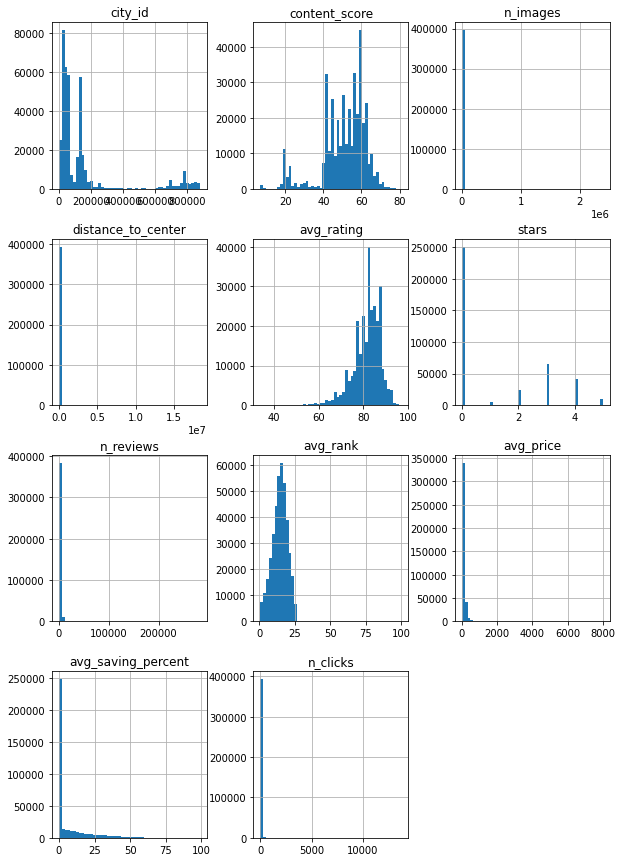

In [14]:
# Now let's look at a histogram for the data

hotel_data.drop(columns = ['hotel_id']).hist(bins = 50, figsize=(10,15))
plt.show()

- > There is big difference between variables in terms of scale.
- > we have many features with heavy tails distribution.

In [14]:
#  To solve this issue we can use power transformation.

### Power Transformation

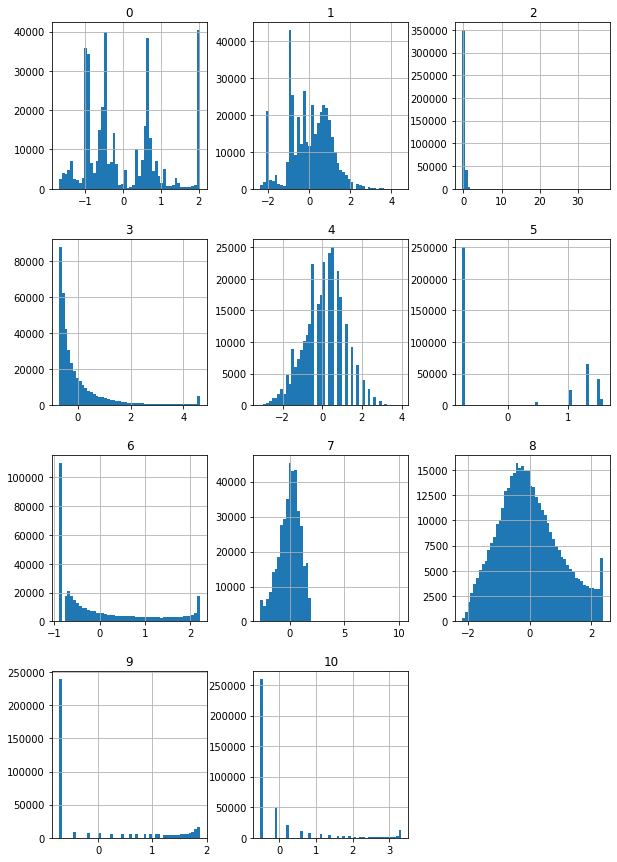

In [17]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
data = pipeline.fit_transform(hotel_data.drop(columns = ['hotel_id']))
# convert the array back to a dataframe
dataset = pd.DataFrame(data)
# histograms of the variables
dataset.hist(bins = 50, figsize=(10,15));


> Some of the features such as avg_price really benefited from this transformation

In [18]:
# Let's calculate Pearson's correlation to see if there is linear relationship between variables
corr_hotel = hotel_data.corr()
corr_hotel ['n_clicks'].sort_values(ascending = False)

n_clicks              1.000000
n_reviews             0.215561
avg_saving_percent    0.133875
stars                 0.130860
content_score         0.095450
avg_price             0.015331
avg_rating            0.005212
n_images              0.002912
distance_to_center   -0.004724
city_id              -0.042874
avg_rank             -0.081410
hotel_id             -0.095660
Name: n_clicks, dtype: float64

In [19]:
# now let's see how the numerical variables are correlated, we will drop city_id since it's categorical variable and hotel_id 
# because it's just an identifier
numerical_vars = ['content_score','n_images','distance_to_center','avg_rating','stars','n_reviews','avg_rank','avg_price','avg_saving_percent',
'n_clicks']

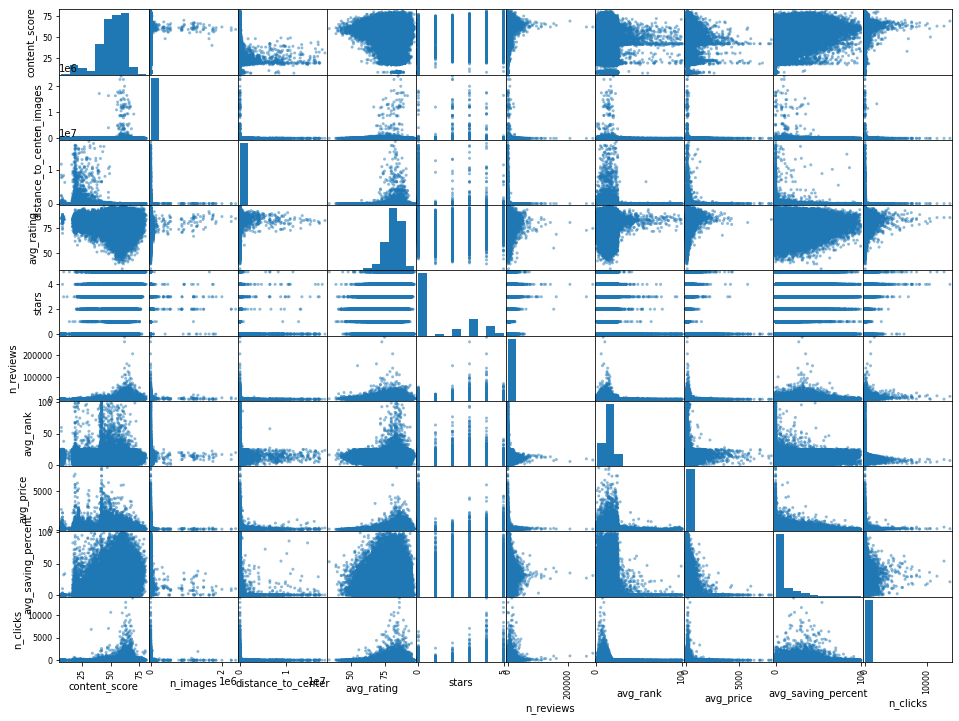

In [20]:
scatter_matrix(hotel_data[numerical_vars],figsize = (16,12));

> Both correlations and scatter matrix indicate that there is no single variable that has a string linear correlation with out target.

In [18]:
## Now le't look at features one by one

In [19]:
#1. hote_id : this column will be dropped

In [8]:
original_size = len(hotel_data)
original_size 

396487

In [9]:
# 2 content score
hotel_data[['content_score']].describe()

,content_score
count,395979.000000
mean,50.992795
std,11.563444
min,7.000000
25%,45.000000
50%,53.000000
75%,59.000000
max,81.000000


In [10]:
hotel_data[hotel_data['content_score'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
34115,1.817005e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.882,136.48,0.0,390
34116,3.682004e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.987,72.79,0.0,24
34117,3.149413e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000,79.03,0.0,0
34118,1.361512e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,375.00,37.0,4
34119,1.599323e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.500,268.95,19.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
396482,1.277185e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.333,103.07,0.0,0
396483,6.841541e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000,44.00,0.0,0
396484,8.649506e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.400,42.78,29.0,4
396485,1.293587e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.143,96.23,36.0,4


> We have 508 rows that have not only content_score as Nan but also `n_images`,`distance_to_center`, `avg_rating`, `stars`, and `n_reviews`

In [11]:
hotel_data = hotel_data[hotel_data['content_score'].notnull()]
len(hotel_data)

395979

In [12]:
# 3 n_images
hotel_data[['n_images']].describe()

,n_images
count,3.959780e+05
mean,2.593212e+02
std,1.731682e+04
min,-1.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,2.393911e+06


> We have some negative `n_images` here we need to remove. Let's first check how many of these we have


In [13]:
hotel_data[hotel_data['n_images'] < 0]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
309,2.310027e+11,40880.0,31.0,-1.0,864.0,NaN,0.0,0.0,16.000,72.00,0.0,0
911,2.390626e+11,43538.0,31.0,-1.0,3428.0,NaN,0.0,0.0,25.000,77.36,0.0,0
930,1.334373e+11,46306.0,32.0,-1.0,992.0,NaN,0.0,0.0,10.000,201.51,1.0,0
958,3.297190e+10,9668.0,37.0,-1.0,169.0,NaN,0.0,0.0,24.000,112.60,0.0,0
1185,2.425277e+11,146322.0,31.0,-1.0,2779.0,NaN,0.0,0.0,24.000,240.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395627,2.247640e+11,193284.0,30.0,-1.0,10044.0,NaN,0.0,0.0,14.000,94.88,0.0,0
395997,1.998287e+11,137512.0,30.0,-1.0,5352.0,NaN,0.0,0.0,24.000,50.80,0.0,0
396212,1.531907e+11,55218.0,9.0,-1.0,0.0,NaN,0.0,0.0,8.596,46.46,0.0,0
396406,2.128680e+11,50126.0,8.0,-1.0,331041.0,NaN,0.0,0.0,19.000,183.08,0.0,0


> 3361 rows, we notice that `avg_rating` for those rows is also NAN, so we will go agead and remove them.


In [14]:
hotel_data = hotel_data[hotel_data['n_images'] >= 0]

In [15]:
len(hotel_data)

392617

In [16]:
# 4 content score
hotel_data[['distance_to_center']].describe()

,distance_to_center
count,3.925970e+05
mean,1.619290e+04
std,2.736377e+05
min,0.000000e+00
25%,5.470000e+02
50%,1.519000e+03
75%,4.162000e+03
max,1.834155e+07


> No negative values here!

In [17]:
hotel_data[hotel_data['distance_to_center'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
30553,1.522385e+11,43532.0,23.0,0.0,NaN,NaN,NaN,NaN,22.000,81.22,1.0,0
39281,5.983448e+10,46946.0,34.0,9.0,NaN,NaN,NaN,NaN,20.333,46.58,0.0,4
75932,5.958532e+10,648742.0,19.0,1.0,NaN,NaN,NaN,NaN,7.200,39.63,0.0,2
90914,2.670061e+09,833300.0,35.0,3.0,NaN,NaN,NaN,NaN,8.500,101.08,44.0,0
108175,5.974874e+10,48872.0,36.0,2.0,NaN,NaN,NaN,NaN,15.667,93.89,0.0,0
137342,6.000239e+10,48800.0,18.0,0.0,NaN,NaN,NaN,NaN,11.500,50.00,0.0,0
168171,5.919428e+10,49648.0,20.0,0.0,NaN,NaN,NaN,NaN,16.600,49.73,0.0,2
186157,5.983479e+10,49192.0,19.0,0.0,NaN,NaN,NaN,NaN,23.000,52.80,0.0,0
186604,1.543787e+09,43538.0,33.0,4.0,NaN,NaN,NaN,NaN,13.510,147.59,31.0,18
196679,5.955871e+10,48954.0,23.0,0.0,NaN,NaN,NaN,NaN,9.278,93.54,0.0,0


> We see that the same rows have NaN's in many other columns, we will drop these

In [18]:
hotel_data = hotel_data[hotel_data['distance_to_center'].notnull()]

In [19]:
# 5 avg_rating
hotel_data[['avg_rating']].describe()

,avg_rating
count,285854.000000
mean,81.614695
std,6.026569
min,34.000000
25%,79.000000
50%,83.000000
75%,86.000000
max,97.000000


> No negative values here!

In [20]:
hotel_data[hotel_data['avg_rating'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
9,9.902959e+10,208612.0,48.0,1.0,1795.0,NaN,0.0,0.0,19.000,21.38,0.0,0
26,1.004976e+11,54398.0,52.0,1.0,1013.0,NaN,0.0,0.0,20.500,56.00,0.0,0
74,1.115944e+11,61992.0,45.0,0.0,144.0,NaN,0.0,0.0,19.000,82.26,0.0,0
81,1.181972e+11,56480.0,49.0,0.0,10417.0,NaN,0.0,0.0,10.500,175.80,0.0,0
93,1.191401e+11,27532.0,46.0,0.0,1321.0,NaN,0.0,0.0,13.000,60.83,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
396467,2.285687e+11,137370.0,41.0,0.0,2129.0,NaN,0.0,0.0,11.727,56.07,0.0,0
396468,2.285979e+11,131846.0,42.0,0.0,6877.0,NaN,0.0,0.0,9.059,69.15,0.0,0
396469,2.288169e+11,878186.0,48.0,1.0,469.0,NaN,0.0,0.0,21.000,78.86,0.0,0
396471,2.290205e+11,31408.0,70.0,1.0,1424.0,NaN,0.0,0.0,16.211,16.11,0.0,4


- > Well this is big chunck of the data with NaN in `avg rating`. Instead of removing these rows, we have to replace them with a suitable value
- > We could use mean, median or 0. For me, I think it makes more sense to replace these value with 0. A missing `avg_rating` is more likely to be 0

In [21]:
hotel_data['avg_rating'] = hotel_data['avg_rating'].fillna(0)

In [22]:
# 6 stars
hotel_data[['stars']].describe()

,stars
count,392564.000000
mean,1.169425
std,1.622986
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,5.000000


> No negative values

In [23]:
hotel_data[hotel_data['stars'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
7188,9.581946e+09,47290.0,48.0,0.0,1995.0,0.0,NaN,0.0,7.677,90.42,0.0,6
7558,2.496446e+09,863642.0,56.0,0.0,1883.0,83.0,NaN,147.0,12.727,87.12,17.0,2
20524,7.789558e+09,49660.0,50.0,1.0,2936.0,0.0,NaN,0.0,14.250,47.11,0.0,0
28720,8.276947e+09,49728.0,49.0,0.0,1504.0,82.0,NaN,81.0,16.100,36.56,0.0,0
37289,9.112159e+09,48884.0,46.0,0.0,2160.0,0.0,NaN,0.0,20.077,97.04,0.0,0
37837,8.214174e+09,49784.0,40.0,0.0,331.0,0.0,NaN,0.0,7.000,38.40,0.0,0
53660,3.507828e+09,31590.0,48.0,2.0,2639.0,81.0,NaN,102.0,18.831,94.42,1.0,6
56492,9.580077e+09,47290.0,51.0,0.0,166.0,0.0,NaN,0.0,7.000,72.97,0.0,0
57893,3.519697e+09,656352.0,45.0,0.0,1873.0,0.0,NaN,0.0,7.000,40.00,0.0,0
63147,7.789247e+09,49660.0,49.0,0.0,614.0,0.0,NaN,0.0,11.750,59.97,0.0,0


> Only 8 rows that can be safely removed!

In [24]:
hotel_data = hotel_data[hotel_data['stars'].notnull()]

In [25]:
# 7 avg_rating
hotel_data[['n_reviews']].describe()

,n_reviews
count,392564.000000
mean,921.502726
std,2441.518357
min,0.000000
25%,0.000000
50%,192.000000
75%,789.000000
max,283089.000000


> No negative values here

In [26]:
hotel_data[hotel_data['n_reviews'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks


> We don't have Nans here!

In [27]:
# 8 avg_rank
hotel_data[['avg_rank']].describe()

,avg_rank
count,392564.000000
mean,14.677311
std,5.594652
min,1.000000
25%,11.074750
50%,15.000000
75%,18.333000
max,100.000000


> No ngative values

In [28]:
hotel_data[hotel_data['avg_rank'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks


> We don't have Nans here

In [29]:
# 9 avg_price
hotel_data[['avg_price']].describe()

,avg_price
count,392411.000000
mean,108.920245
std,146.944074
min,4.000000
25%,51.020000
50%,77.590000
75%,120.640000
max,8000.000000


> No negative values here.

In [30]:
hotel_data[hotel_data['avg_price'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
1016,4.191063e+10,7696.0,54.0,2.0,2883.0,83.0,0.0,2625.0,1.0,NaN,NaN,0
6487,3.863003e+09,138846.0,59.0,3.0,912.0,83.0,0.0,90.0,1.0,NaN,NaN,0
8321,1.225554e+11,192284.0,52.0,0.0,273.0,80.0,0.0,66.0,12.0,NaN,NaN,0
12298,1.545662e+11,27126.0,47.0,0.0,1977.0,0.0,0.0,0.0,13.0,NaN,NaN,0
17758,1.203430e+11,140508.0,47.0,0.0,14832.0,0.0,0.0,0.0,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
388350,1.532225e+11,38928.0,44.0,0.0,318.0,0.0,0.0,0.0,18.0,NaN,NaN,0
388546,2.118243e+11,54438.0,42.0,1.0,5730.0,85.0,0.0,255.0,1.0,NaN,NaN,0
388939,2.249208e+11,30600.0,47.0,0.0,5461.0,0.0,0.0,0.0,1.0,NaN,NaN,0
394115,3.176726e+11,63440.0,44.0,0.0,1611.0,0.0,0.0,0.0,1.0,NaN,NaN,0


> We have 153 rows, we can see that in the same raws we have Nan in avg_saving_percent, we can go ahead and remove those


In [31]:
hotel_data = hotel_data[hotel_data['avg_price'].notnull()]

In [32]:
len(hotel_data)

392411

In [33]:
# 20 avg_price
hotel_data[['avg_saving_percent']].describe()

,avg_saving_percent
count,392411.000000
mean,7.238839
std,13.119062
min,0.000000
25%,0.000000
50%,0.000000
75%,10.000000
max,99.000000


> No negative values here!

In [34]:
hotel_data[hotel_data['avg_saving_percent'].isnull()]

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks


> No NaNs any more!

In [35]:
# 11 city_id : This is categorical variable. Usually we use one-hot encoding with this type variable. Let's see if it is feasible to apply this strategy here

In [36]:
city_id_count = hotel_data['city_id'].value_counts().reset_index(name='count').rename(columns={'index': 'city_id'})
city_id_count 

,city_id,count
0,50168.0,2486
1,44470.0,1672
2,34798.0,1580
3,30576.0,1360
4,26874.0,1126
...,...,...
33152,381922.0,1
33153,763852.0,1
33154,190964.0,1
33155,763902.0,1


> we have 33,157 unique values for city_id

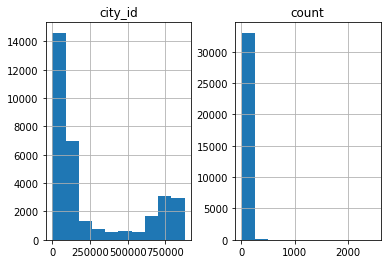

In [37]:
city_id_count .hist();

> We note here that many of these city_ids have low frequency.

- Encoding this categorical variable will result in high dimentional data that was too big to my pc memory. And as we noted above most of these `city_id's` have low frequency, therefore I am going to replace each `cit_id` with it's count,i.e how much it appears in the dat set and will then treat it as a numerical variable

### Creating new numerical feature for city_id

In [38]:
# we will merge the original data with the city_id_count from above

In [39]:
hotel_data = pd.merge(hotel_data,city_id_count ,on=['city_id'], how='left' )
hotel_data

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks,count
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0,80
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4,751
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44,429
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4,5
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392406,2.288169e+11,878186.0,48.0,1.0,469.0,0.0,0.0,0.0,21.000,78.86,0.0,0,16
392407,2.289822e+11,27338.0,42.0,0.0,689.0,83.0,0.0,72.0,14.174,116.56,4.0,0,66
392408,2.290205e+11,31408.0,70.0,1.0,1424.0,0.0,0.0,0.0,16.211,16.11,0.0,4,11
392409,2.292421e+11,10718.0,42.0,0.0,164.0,84.0,0.0,222.0,20.000,253.81,0.0,0,5


In [40]:
# now we can drop the original city_id columns
hotel_data = hotel_data.drop(columns = ['city_id'])

In [41]:
# Finally let's look at our target variable

In [42]:
hotel_data[['n_clicks']].describe()

,n_clicks
count,392411.000000
mean,13.905808
std,124.163689
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13742.000000


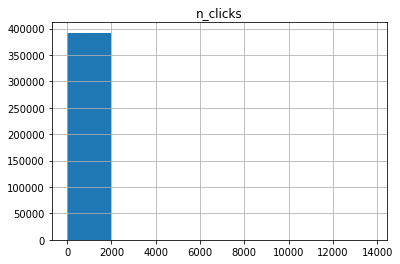

In [43]:
# let's check the distribution of n_clicks
hotel_data[['n_clicks']].hist(bins=7);

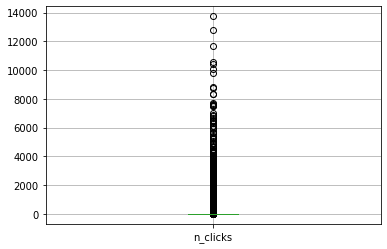

In [44]:
hotel_data[['n_clicks']].boxplot();

In [45]:
# it seems we have a lot of outliers, let's see how many of those is are out side the range between the 5 and 95 quantiles

y = hotel_data['n_clicks']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

print(str(y[removed_outliers].size) + "/" + str(len(hotel_data)) + " data points remain.") 

372930/392411 data points remain.


In [46]:
index_names = hotel_data[~removed_outliers].index 

In [47]:
hotel_data.drop(index_names, inplace=True)

In [48]:
len(hotel_data)

372930

> We will loose around 20,000 rows. let's go ahead and remove those outliers

In [49]:
### Now let's look at the data type for each column

In [53]:
hotel_data.dtypes

hotel_id              float64
content_score         float64
n_images              float64
distance_to_center    float64
avg_rating            float64
stars                 float64
n_reviews             float64
avg_rank              float64
avg_price             float64
avg_saving_percent    float64
n_clicks              float64
count                 float64
dtype: object

In [54]:
# let's convert n_clicks to float as we expect out model to output float numbers for n_clicks

In [55]:
hotel_data['count'] = hotel_data['count'].astype(float)
hotel_data['n_clicks'] = hotel_data['n_clicks'].astype(float)


In [56]:
hotel_data.to_csv('cleaned.csv', index = False)